# IMA-205
# TP ANN (part B) 2021/03/29

## Coding a Multi-Layer Perceptron with Tensorflow
Author : Alasdair Newson

In the second part of this TP, we will be looking at the Multi-Layer Perceptron (MLP) using Tensorflow (http://www.tensorflow.org)

We will be using the following packages :
   
   - Scikit-learn (http://scikit-learn.org/)
   - Tensorflow (http://www.tensorflow.org)

The following commands will make sure that you have all the necessary packages

In [1]:
%matplotlib inline                      

import numpy as np
import matplotlib.pyplot as plt
import os
import pdb

import sklearn  # scikit-learn
import tensorflow as tf

# import tensorflow models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import optimizers
print(tf.keras.__version__)

2.4.0


# 1 - Multi-Layer Perceptron with Tensorflow

## Introduction to TensorFlow

Tensorflow is an environment written by Google which allows easy implementation of deep neural networks. In particular, it provides automatic differentiation so that the user does not have to determine gradients manually, which can be extremely long even for simple networks, as you have seen in the previous TP*.

This, in turn allows a user to apply techniques such as stochastic gradient descent for training purposes. The differentiation graph is created symbolically when the network is created. Since a neural network is simply a cascade (or concatenation) of simple functions, the network in Tensorflow is simply a sequence of functions which are applied to one or several variables. The output of the final function is the output of the network.

For instance, if the input were ```x``` and the network consisted of two functions ```a``` and ```b```, you could create the network simply by writing :

```y = b(a(x))```

However, it is clear that these functions and variables must be of some special type, so that the computer can figure out how to carry out the automatic differentiation for training. Tensorflow provides these functions and variables, which must be created with the Tensorflow package.

Previously, Tensorflow required a strict separation between the creation (declaration) of variables and their execution (giving a numerical value, using the ```Session``` function). With Keras and Tensorflow 2, this separation has been removed, and the language has become simpler, in particular for creating and training networks.

## Creating a network

To create a network, there are two (main) methods :

### Creating a model using the Sequential API

Tensorflow has a simple way of adding layers to create a neural network. First, you can indicate to Tensorflow that the model is 'sequential' (a simple model, with not many tweaks). For this, you can use the following function :
- ```model = Sequential()```

After this, you can add layers with the function.

- ```model.add()```

You can then use the ```Dense``` (and other) functions to specify different layer types.  __Note that in the case of this approach, you will have to specify the input image size in the first layer of the network, inside the first layer function.__ So, for example, if the first layer is a dense layer with a relu activation, with n_out output neurons, and n_input neurons :

- model = Sequential()
- model.add(Dense(n_out,activation,input_shape=(n_in,),activation='relu'))

Otherwise, the network does not know how many weights to create. __Be careful of this special case (the first layer)__ 

### Creating a model using the standard API

Otherwise, another approach to creating the model is to explicitly create the input variable, and just cascade the different functions, as in Tensorflow. So, for the same example, we would have :

- input = Input(shape=(n_in,))
- output = Dense(n_in,n_out,activation='relu')(input)
- model = Model(input, output)


For now, let's use the Sequential API (however, if you want to try the standard API, go ahead).

## Training and testing a network

Tensorflow allows the easy training of a network with the following functions :

- model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=learning_rate)) : create the loss function and define the optimiser used. This function can do many other useful things (such as specifying different metrics to look at the model's performance

- model.fit(...) : train the model
- model.evaluate(...) : test the model
- model.predict(...) : carry out a simple forward pass on the model

Please look at the Tensorflow documenation for further details on these functions.


# MLP with TensorFlow

We are now going to create an MLP with tensorflow. We will start with an MLP with one hidden layer. The network should consist of the following operations, in the following order :

- Fully connected layer, with weights w1 and biases b1
- ReLU activation
- Fully connected layer, with weights w2 and biases b2
- Sigmoid output activation

We are going to be solving a binary classification 
problem, so the output of the network should be a scalar between 0 and 1 (thus the last layer is a Sigmoid activation).

The loss function should be defined as the binary cross-entropy between the predicted class and the true class


First, we load the data.

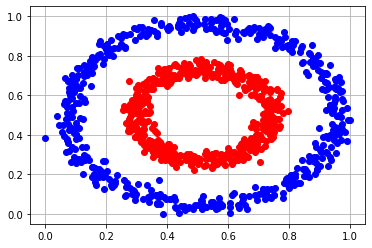

In [2]:
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

X, Y = datasets.make_circles(n_samples=1000, noise=0.05, factor=0.5)
# X, y = datasets.make_moons(n_samples=1000, random_state=42)  # try with 2 moons
X = MinMaxScaler().fit_transform(X)

#show data in plot
plt.plot(X[Y == 1, 0], X[Y == 1, 1], 'ro')
plt.plot(X[Y == 0, 0], X[Y == 0, 1], 'bo')
plt.grid('on')

We are now going to define some useful auxillary functions.

First, a function that shows the decision boundary of our network. This works only for 2D input data

In [3]:
# THIS CODE IS GIVEN

def plot_decision_function_2d(model_mlp, X, Y):
   # create a mesh to plot in
    h = .02  # step size in the mesh
    offset = 0.1
    x_min, x_max = X[:, 0].min() - offset, X[:, 0].max() + offset
    y_min, y_max = X[:, 1].min() - offset, X[:, 1].max() + offset
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    Z = model_mlp.predict(np.c_[xx.ravel(), yy.ravel()])
    print(Z.shape)
    print(Z)
    
    Z = Z<0.5
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

    plt.plot(X[Y == 1, 0], X[Y == 1, 1], 'yo')
    plt.plot(X[Y == 0, 0], X[Y == 0, 1], 'ko')

    plt.title("Decision surface")
    plt.axis('tight')

## CREATING AND TRAINING THE MODEL

We are now ready to create our network with a Tensorflow Session and to carry out training on our training dataset.

In [28]:
# FILL IN CODE BY STUDENTS IN THIS SECTION

#We split up the data into training and test data, using a function from Scikit-learn :
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15)
print(X_train.shape)

# Layer sizes
n_input = X.shape[1]  # Number of input features
n_hidden = 50  # Number of hidden nodes

# create the model (using the sequential API)

model_mlp = Sequential()  # FILL IN STUDENTS
model_mlp.add(Dense(n_hidden,input_dim=n_input, activation="relu"))
model_mlp.add(Dense(1, activation="sigmoid"))

# create the loss and optimiser
learning_rate = 0.01
model_mlp.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=learning_rate),metrics=["accuracy"]) # TO FILL IN

# Run optimisation algorithm()
n_epochs = 20
batch_size = 64

print('Training')
model_mlp.fit(X_train, Y_train, epochs=n_epochs, batch_size=batch_size) # TO FILL IN

print('Testing')
model_mlp.evaluate(X_test,  Y_test, verbose=2) # TO FILL IN


(850, 2)
Training
Epoch 1/20
14/14 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.4505
Epoch 2/20
14/14 [==============================] - 0s 2ms/step - loss: 0.6770 - accuracy: 0.6168
Epoch 3/20
14/14 [==============================] - 0s 2ms/step - loss: 0.6623 - accuracy: 0.5592
Epoch 4/20
14/14 [==============================] - 0s 2ms/step - loss: 0.6364 - accuracy: 0.7276
Epoch 5/20
14/14 [==============================] - 0s 2ms/step - loss: 0.6121 - accuracy: 0.7516
Epoch 6/20
14/14 [==============================] - 0s 2ms/step - loss: 0.5839 - accuracy: 0.7629
Epoch 7/20
14/14 [==============================] - 0s 2ms/step - loss: 0.5531 - accuracy: 0.7500
Epoch 8/20
14/14 [==============================] - 0s 2ms/step - loss: 0.5362 - accuracy: 0.7847
Epoch 9/20
14/14 [==============================] - 0s 2ms/step - loss: 0.5101 - accuracy: 0.8001
Epoch 10/20
14/14 [==============================] - 0s 2ms/step - loss: 0.4655 - accuracy: 0.8359
E

[0.1536875218153, 1.0]

(3363, 1)
[[0.00022229]
 [0.00028085]
 [0.00035481]
 ...
 [0.00263037]
 [0.00221621]
 [0.00183064]]


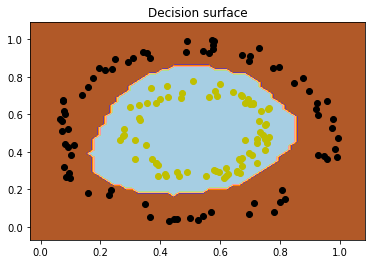

In [29]:
plot_decision_function_2d(model_mlp, X_test, Y_test)

# MLP with several hidden layers

We are now going to create an MLP with several hidden layers. We are going to use a more complicated dataset : the MNIST dataset, which contains images of handwritten digits. There are 10 classes, one for each digit.

We are going to implement the following architecture :

- Fully connected layer
- Relu activation
- Fully connected layer
- Relu activation
- Fully connected layer
- Relu activation
- Fully connected layer
- Softmax output activation

__IMPORTANT Note__ The sigmoid layer has been replaced by a softmax layer (at the end). This is normal, since we have a multi-class problem.


First, we load the MNIST dataset.

In [30]:
# Import MNIST data
mnist = tf.keras.datasets.mnist
(X_train, y_train),(X_test, y_test) = mnist.load_data()

Y_train = tf.keras.utils.to_categorical(y_train)  # in order to convert y to a matrix with (num_examples, num_classes) (one-hot encoding)
Y_test = tf.keras.utils.to_categorical(y_test)  # in order to convert y to a matrix with (num_examples, num_classes) (one-hot encoding)

#reshape the input images : flatten the last two dimensions
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1]*X_train.shape[2]))
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1]*X_test.shape[2]))


11493376/11490434 [==============================] - 0s 0us/step


Finally, fill in the following code to create and train your MLP

In [31]:

# Network Parameters
n_hidden_1 = 256 # 1st layer number of neurons
n_hidden_2 = 256 # 2nd layer number of neurons
n_hidden_3 = 128 # 2nd layer number of neurons

n_input = X_train.shape[1]
n_classes = Y_train.shape[1] # MNIST total classes (0-9 digits)

# TO CODE BY STUDENTS

model_mlp_multi_layer = Sequential() 
model_mlp_multi_layer.add(Dense(n_hidden_1,input_dim=n_input, activation="relu"))
model_mlp_multi_layer.add(Dense(n_hidden_2, activation="relu"))
model_mlp_multi_layer.add(Dense(n_hidden_3, activation="relu"))
model_mlp_multi_layer.add(Dense(n_classes, activation="softmax"))

# create the loss and optimiser, use 'categorical_crossentropy' in loss
learning_rate = 0.01
model_mlp_multi_layer.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=learning_rate),metrics=["accuracy"])

# Run optimisation algorithm
n_epochs = 20
batch_size = 64

print('Training')
model_mlp_multi_layer.fit(X_train, Y_train, epochs=n_epochs, batch_size=batch_size)

print('Testing')
model_mlp_multi_layer.evaluate(X_test,  Y_test, verbose=2) # TO FILL IN


Training
Epoch 1/20
938/938 [==============================] - 3s 2ms/step - loss: 16.0812 - accuracy: 0.6343
Epoch 2/20
938/938 [==============================] - 2s 2ms/step - loss: 0.4557 - accuracy: 0.8808
Epoch 3/20
938/938 [==============================] - 2s 2ms/step - loss: 0.3666 - accuracy: 0.9032
Epoch 4/20
938/938 [==============================] - 2s 2ms/step - loss: 0.3984 - accuracy: 0.8980
Epoch 5/20
938/938 [==============================] - 2s 2ms/step - loss: 0.4115 - accuracy: 0.8972
Epoch 6/20
938/938 [==============================] - 2s 2ms/step - loss: 0.5872 - accuracy: 0.8395
Epoch 7/20
938/938 [==============================] - 2s 2ms/step - loss: 0.5304 - accuracy: 0.8637
Epoch 8/20
938/938 [==============================] - 2s 2ms/step - loss: 0.6042 - accuracy: 0.8485
Epoch 9/20
938/938 [==============================] - 2s 2ms/step - loss: 0.8888 - accuracy: 0.7322
Epoch 10/20
938/938 [==============================] - 2s 3ms/step - loss: 0.7764 - accura

[0.7745332717895508, 0.7831000089645386]

In [32]:
# THIS CODE IS GIVEN

def test_mnist_images(model_mlp_multi_layer,X_test):
  plt.figure(figsize=(10, 6))
  for idx in range(0,10):
      plt.subplot(2, 5, idx+1)
      rand_ind = np.random.randint(0,X_test.shape[0])
      plt.imshow(np.reshape(X_test[rand_ind,:],(28,28)),cmap='gray')
      # get prediction
      model_prediction = np.argmax(model_mlp_multi_layer.predict(np.expand_dims( X_test[rand_ind,:], axis=0)),axis=1)
      plt.title(int(model_prediction))

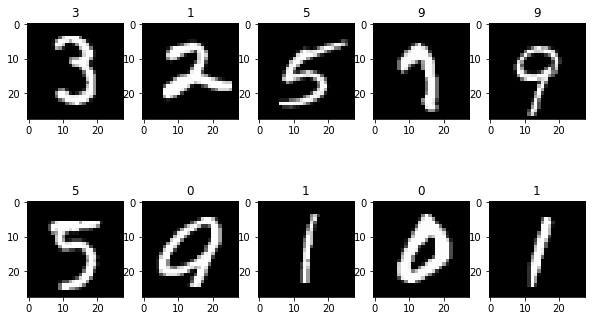

In [33]:
test_mnist_images(model_mlp_multi_layer,X_test)

You may observe some difficulties in getting good performance in this case. To improve training, we can turn to __regularisation__

## BATCH NORMALISATION

One approach to regularisation which we have seen during the lesson is known as batch normalisation, which we have seen during the lesson. This can be implemented very simply in Tensorflow by adding the following layer :

- ```BatchNormalization()```

Change your model below, and implement this using your code above

In [35]:
from tensorflow.keras.layers import Dense, BatchNormalization

# Network Parameters
n_hidden_1 = 256 # 1st layer number of neurons
n_hidden_2 = 256 # 2nd layer number of neurons
n_hidden_3 = 128 # 2nd layer number of neurons

n_input = X_train.shape[1]
n_classes = Y_train.shape[1] # MNIST total classes (0-9 digits)

# TO CODE BY STUDENTS

model_mlp_multi_layer = Sequential() 
model_mlp_multi_layer.add(Dense(n_hidden_1,input_dim=n_input, activation="relu"))
model_mlp_multi_layer.add(BatchNormalization())
model_mlp_multi_layer.add(Dense(n_hidden_2, activation="relu"))
model_mlp_multi_layer.add(BatchNormalization())
model_mlp_multi_layer.add(Dense(n_hidden_3, activation="relu"))
model_mlp_multi_layer.add(BatchNormalization())
model_mlp_multi_layer.add(Dense(n_classes, activation="softmax"))

# create the loss and optimiser, use 'categorical_crossentropy' in loss
learning_rate = 0.01
model_mlp_multi_layer.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=learning_rate),metrics=["accuracy"])

# Run optimisation algorithm
n_epochs = 20
batch_size = 64

print('Training')
model_mlp_multi_layer.fit(X_train, Y_train, epochs=n_epochs, batch_size=batch_size)

print('Testing')
model_mlp_multi_layer.evaluate(X_test,  Y_test, verbose=2) # TO FILL IN

Training
Epoch 1/20
938/938 [==============================] - 4s 4ms/step - loss: 0.3316 - accuracy: 0.9003
Epoch 2/20
938/938 [==============================] - 4s 4ms/step - loss: 0.1339 - accuracy: 0.9587
Epoch 3/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0984 - accuracy: 0.9692
Epoch 4/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0808 - accuracy: 0.9749
Epoch 5/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0702 - accuracy: 0.9780
Epoch 6/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0614 - accuracy: 0.9808
Epoch 7/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0569 - accuracy: 0.9816
Epoch 8/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0469 - accuracy: 0.9849
Epoch 9/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0451 - accuracy: 0.9852
Epoch 10/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0384 - accurac

[0.09033944457769394, 0.9801999926567078]

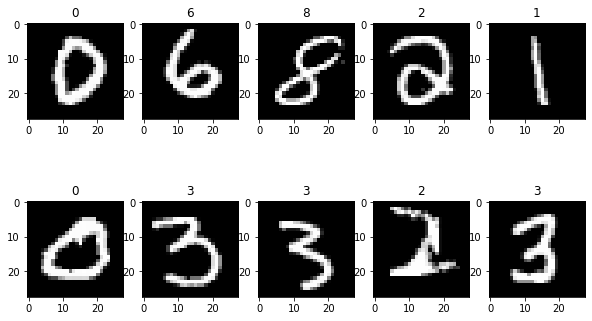

In [37]:
test_mnist_images(model_mlp_multi_layer,X_test)

Question : do you observe improved convergence ?

**Answer:** Yes. In the first case (before the batch normalization), the accuracy at each epoch varies a lot, that is, it sometimes gets worst. After the batch normalization, the accuracy overall increases constantly. We also converge to good results quicker. Our results in the test show us that in fact we obtained good results, and didn’t fall in a overfitting case. 

#### Documentation:

  - http://www.tensorflow.org
  - http://www.deeplearningbook.org/